# Bollinger Bands 

In this notebook, we walk through the process of implementing the Bollinger Bands strategy for stock trading using Python. Starting from data acquisition using Yahoo Finance, we calculate the Bollinger Bands (upper, lower, and middle) and generate buy/sell signals based on the stock's movement in relation to the bands. We also simulate a simple backtest strategy to execute actual buys and sells, visualizing these trades along with the price and Bollinger Bands. This notebook provides a practical introduction to applying technical analysis and algorithmic trading strategies in real-life scenarios.

## Import Libraries

In [128]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from tabulate import tabulate
import numpy as np

## Data

### Define parameters

In [129]:
# Define the stock symbol and the date range for our data
stock_symbol = 'TSLA'
start_date = '2024-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')  # Sets end date to today's date
print(f"Bollinger Bands Trading for: {stock_symbol}\nStart Date: {start_date}\nEnd Date: {end_date}")

Bollinger Bands Trading for: TSLA
Start Date: 2024-01-01
End Date: 2024-11-25


### Download Data

In [130]:
df = yf.download(stock_symbol, start=start_date, end=end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2024-01-02,248.419998,248.419998,251.250000,244.410004,250.080002,104654200
2024-01-03,238.449997,238.449997,245.679993,236.320007,244.979996,121082600
2024-01-04,237.929993,237.929993,242.699997,237.729996,239.250000,102629300
2024-01-05,237.490005,237.490005,240.119995,234.899994,236.860001,92379400
2024-01-08,240.449997,240.449997,241.250000,235.300003,236.139999,85166600


### Process Data

In [131]:
# Select the desired columns (first level of MultiIndex)
df.columns = df.columns.get_level_values(0)

# Keep only the columns you are interested in
df = df[['Open', 'Close', 'Volume', 'Low', 'High']]

# If the index already contains the dates, rename the index
df.index.name = 'Date'  # Ensure the index is named "Date"
    
# Resetting the index if necessary
df.reset_index(inplace=True)

# Ensure that the index is of type datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index again (in case it's reset)
df.set_index('Date', inplace=True)

df.head()

Price,Open,Close,Volume,Low,High
Date,,,,,
2024-01-02,250.080002,248.419998,104654200,244.410004,251.250000
2024-01-03,244.979996,238.449997,121082600,236.320007,245.679993
2024-01-04,239.250000,237.929993,102629300,237.729996,242.699997
2024-01-05,236.860001,237.490005,92379400,234.899994,240.119995
2024-01-08,236.139999,240.449997,85166600,235.300003,241.250000


### Visualize Chart

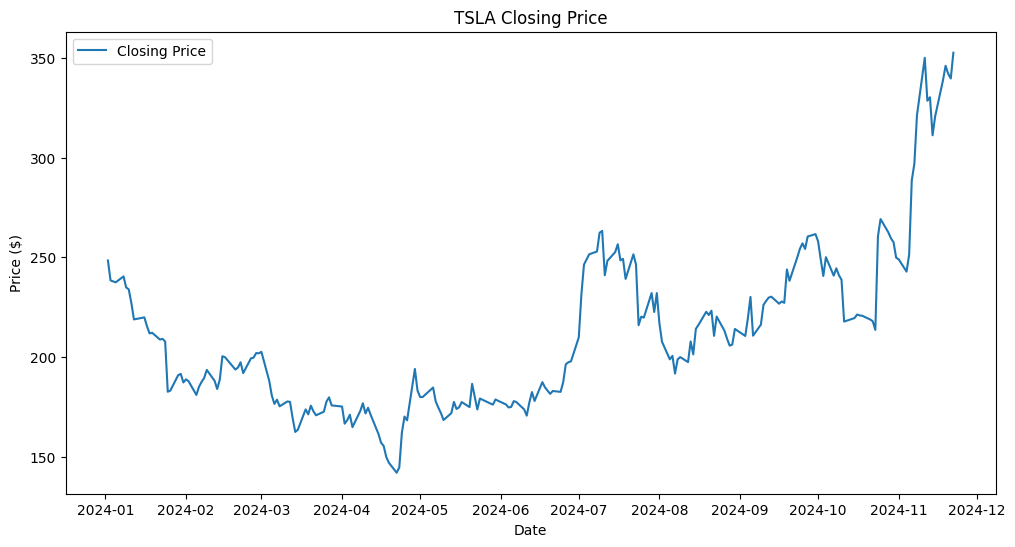

In [132]:
# Plot the closing price
plt.figure(figsize=(12, 6))

plt.plot(df['Close'], label='Closing Price')

# Add title, labels, and legend
plt.title(f'{stock_symbol} Closing Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()

# Save the plot in 300dpi
plt.savefig(f'{stock_symbol}_stock_chart.png', dpi=300)

# Show the plot
plt.show()

## Backtest Bollinger Bands Strategy

### Generate Signals

In [133]:
# Define the period and standard deviations for Bollinger Bands
window = 10  # Period for the moving average (e.g., 20 days)
num_std_dev = 2  # Number of standard deviations for the upper and lower bands

# Calculate the rolling mean (middle band) and rolling standard deviation
df['Middle_Band'] = df['Close'].rolling(window=window).mean()
df['Std_Dev'] = df['Close'].rolling(window=window).std()

# Calculate the upper and lower bands
df['Upper_Band'] = df['Middle_Band'] + (df['Std_Dev'] * num_std_dev)
df['Lower_Band'] = df['Middle_Band'] - (df['Std_Dev'] * num_std_dev)

# Generate the Buy, Hold, Sell signals (1 for Buy, 0 for Hold, -1 for Sell)
# Buy Signal: when the close price is below the lower band and the previous close was above it
df['Signal'] = 0  # Initialize the Signal column as 0 (Hold)
df.loc[(df['Close'] < df['Lower_Band']) & (df['Close'].shift(1) >= df['Lower_Band']), 'Signal'] = 1  # Buy Signal

# Sell Signal: when the close price is above the upper band and the previous close was below it
df.loc[(df['Close'] > df['Upper_Band']) & (df['Close'].shift(1) <= df['Upper_Band']), 'Signal'] = -1  # Sell Signal

# Inspect the dataframe with the combined signal column
df.tail()  # Check the last few rows to see the generated signals


Price,Open,Close,Volume,Low,High,Middle_Band,Std_Dev,Upper_Band,Lower_Band,Signal
Date,,,,,,,,,,
2024-11-18,340.730011,338.739990,126547500,330.010010,348.549988,313.746997,28.559695,370.866387,256.627607,0
2024-11-19,335.760010,346.000000,88852500,332.750000,347.380005,323.202997,20.013442,363.229882,283.176112,0
2024-11-20,345.000000,342.029999,66340700,334.299988,346.600006,328.552997,16.569232,361.691461,295.414532,0
2024-11-21,343.809998,339.640015,58011700,335.279999,347.989990,332.825998,12.516268,357.858534,307.793462,0
2024-11-22,341.089996,352.559998,88896400,337.700012,361.529999,335.959998,13.192695,362.345387,309.574608,0


### Visualize Bollinger Bands

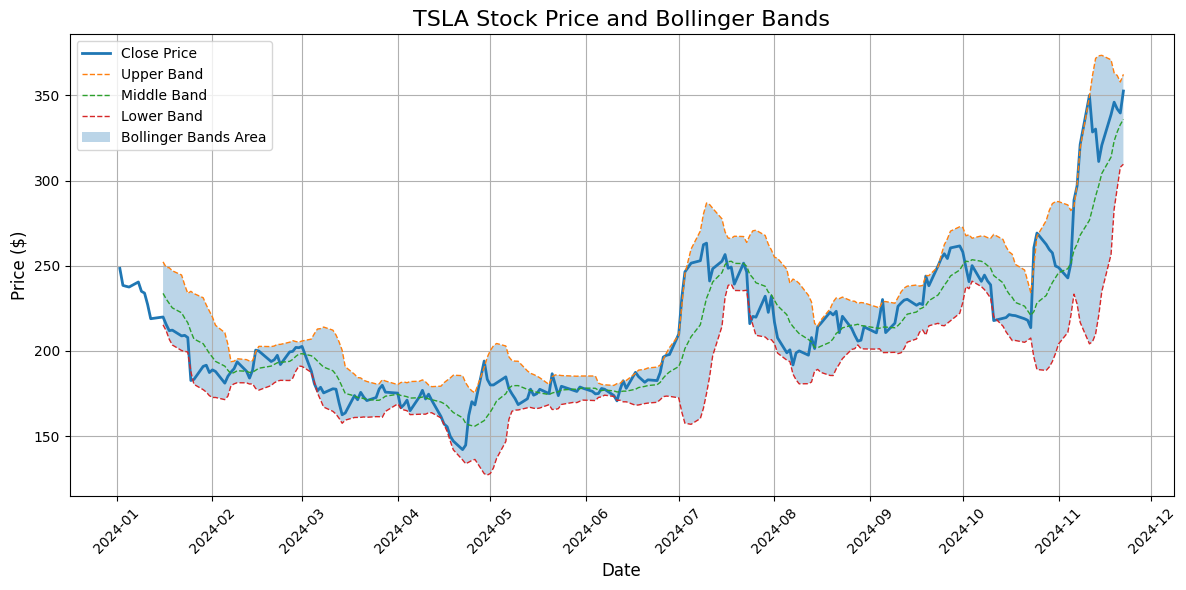

In [134]:
# Plotting the stock price, Bollinger Bands, and Buy/Sell signals
plt.figure(figsize=(12, 6))

# Plot the closing price
plt.plot(df.index, df['Close'], label='Close Price', linewidth=2)

# Plot the Middle, Upper and Lower Bands (dashed lines)
plt.plot(df.index, df['Upper_Band'], label='Upper Band', linestyle='--', linewidth=1)
plt.plot(df.index, df['Middle_Band'], label='Middle Band', linestyle='--', linewidth=1)
plt.plot(df.index, df['Lower_Band'], label='Lower Band', linestyle='--', linewidth=1)

# Fill the area between the Upper and Lower Bands (shading the middle area)
plt.fill_between(df.index, df['Lower_Band'], df['Upper_Band'], alpha=0.3, label='Bollinger Bands Area')


# Adding titles and labels
plt.title(f'{stock_symbol} Stock Price and Bollinger Bands', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(loc='best')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show gridlines for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()

# Save the Figure
plt.savefig(f'{stock_symbol}_bollinger_bands.png', dpi=300)

# Show the figure
plt.show()


### Calculate the Brokerage Fee
We define a function to calculate the brokerage fee for each transaction. The fee is set to 0.25% of the transaction amount, with a minimum fee of $0.01 to ensure that small transactions still incur a reasonable fee. This helps simulate the costs associated with trading, making the strategy more realistic.

In [135]:
# Define the fee calculation function
def calculate_fee(amount: float) -> float:
    """Calculate the brokerage fee based on transaction amount."""
    fee = amount * 0.0025  # 0.25% of the transaction
    return max(fee, 0.01)   # Minimum fee of $0.01

### Backtest

In [136]:
# Initialize backtest parameters
initial_cash = 100
cash = initial_cash
shares = 0
transaction_details = []

# Backtest loop
for i in range(len(df)):
    # Buy signal: buy if `Position` changes to 1, no position held, and cash is available
    if df.iloc[i]['Signal'] == 1 and cash > 0:
        price = df['Close'].iloc[i]
        shares_to_buy = cash / price
        cost = shares_to_buy * price
        fee = calculate_fee(cost)
        total_cost = cost + fee

        if shares_to_buy > 0:
            cash -= total_cost
            shares += shares_to_buy
            transaction_details.append([df.index[i].date(), "BUY", round(price, 2), round(fee, 2), round(cash + shares * price, 2)])

    # Sell signal: sell if `Position` changes to -1, position held, and shares are available
    elif df.iloc[i]['Signal'] == -1 and shares > 0:
        price = df['Close'].iloc[i]
        sale_value = shares * price
        fee = calculate_fee(sale_value)
        net_sale = sale_value - fee

        cash += net_sale
        shares = 0  # Reset shares after selling
        transaction_details.append([df.index[i].date(), "SELL", round(price, 2), round(fee, 2), round(cash, 2)])


### Visualize trading results

In [137]:
# Display transaction details
print(tabulate(transaction_details, headers=["Date", "Action", "Price ($)", "Fee ($)", "Portfolio Value ($)"], tablefmt="pretty"))

# Final portfolio value
final_value = cash + (shares * df['Close'].iloc[-1])
profit = final_value - initial_cash
print(f"\nInitial Portfolio Value: ${initial_cash:.2f}")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Profit/Loss: ${profit:.2f}")

+------------+--------+-----------+---------+---------------------+
|    Date    | Action | Price ($) | Fee ($) | Portfolio Value ($) |
+------------+--------+-----------+---------+---------------------+
| 2024-01-25 |  BUY   |  182.63   |  0.25   |        99.75        |
| 2024-02-15 |  SELL  |  200.45   |  0.27   |       109.23        |
| 2024-03-05 |  BUY   |  180.74   |  0.27   |       108.96        |
| 2024-04-29 |  SELL  |  194.05   |  0.29   |       116.71        |
| 2024-06-11 |  BUY   |  170.66   |  0.29   |       116.42        |
| 2024-06-17 |  SELL  |  187.44   |  0.32   |       127.57        |
| 2024-07-24 |  BUY   |  215.99   |  0.32   |       127.26        |
| 2024-09-05 |  SELL  |  230.17   |  0.34   |       135.29        |
| 2024-10-11 |  BUY   |   217.8   |  0.34   |       134.95        |
| 2024-10-24 |  SELL  |  260.48   |   0.4   |       161.06        |
+------------+--------+-----------+---------+---------------------+

Initial Portfolio Value: $100.00
Final Portfoli

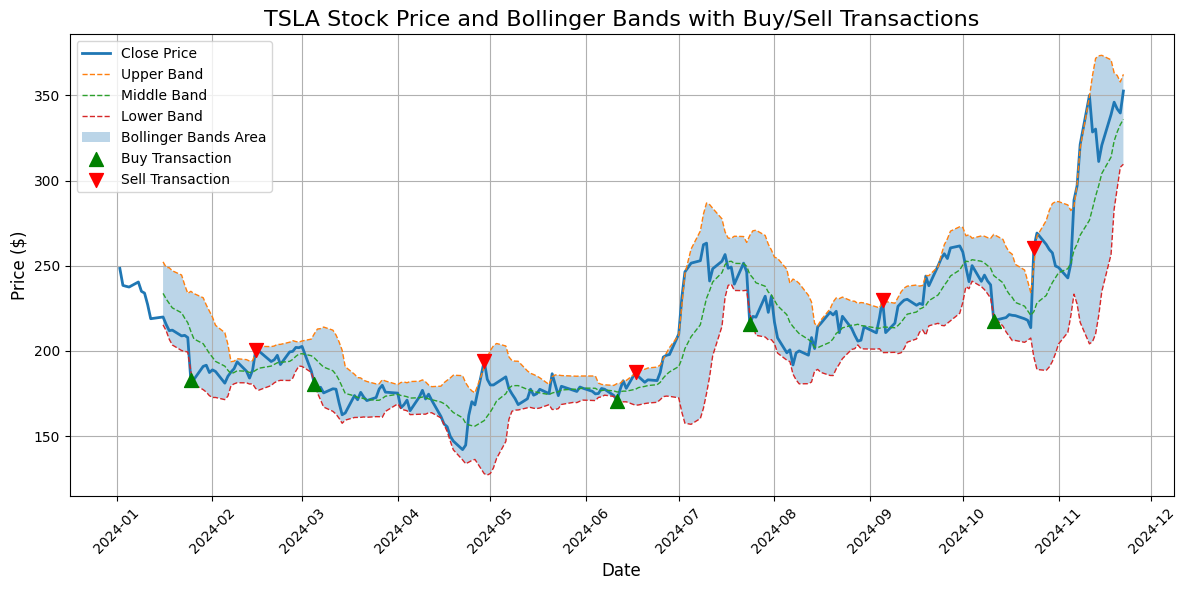

In [138]:
# Extract the Buy and Sell prices and corresponding dates from transaction_details
buy_dates = [x[0] for x in transaction_details if x[1] == 'BUY']
buy_prices = [x[2] for x in transaction_details if x[1] == 'BUY']

sell_dates = [x[0] for x in transaction_details if x[1] == 'SELL']
sell_prices = [x[2] for x in transaction_details if x[1] == 'SELL']

# Plotting the stock price, Bollinger Bands, and Buy/Sell signals
plt.figure(figsize=(12, 6))

# Plot the closing price
plt.plot(df.index, df['Close'], label='Close Price', linewidth=2)

# Plot the Upper and Lower Bands (dashed lines)
plt.plot(df.index, df['Upper_Band'], label='Upper Band', linestyle='--', linewidth=1)
plt.plot(df.index, df['Middle_Band'], label='Middle Band', linestyle='--', linewidth=1)
plt.plot(df.index, df['Lower_Band'], label='Lower Band', linestyle='--', linewidth=1)

# Fill the area between the Upper and Lower Bands (shading the middle area)
plt.fill_between(df.index, df['Lower_Band'], df['Upper_Band'], alpha=0.3, label='Bollinger Bands Area')

# Plot Buy and Sell transactions as green and red arrows
# Green arrows for actual buy prices (buy signal occurred)
plt.scatter(buy_dates, buy_prices, marker='^', color='green', label='Buy Transaction', s=100, zorder=5)

# Red arrows for actual sell prices (sell signal occurred)
plt.scatter(sell_dates, sell_prices, marker='v', color='red', label='Sell Transaction', s=100, zorder=5)

# Adding titles and labels
plt.title(f'{stock_symbol} Stock Price and Bollinger Bands with Buy/Sell Transactions', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(loc='best')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show gridlines for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()

# Save the Figure
plt.savefig(f'{stock_symbol}_bollinger_bands_buy_sell.png', dpi=300)

plt.show()
